# Inżynieria lingwistyczna
Ten notebook jest oceniany półautomatycznie. Nie twórz ani nie usuwaj komórek - struktura notebooka musi zostać zachowana. Odpowiedź wypełnij tam gdzie jest na to wskazane miejsce - odpowiedzi w innych miejscach nie będą sprawdzane (nie są widoczne dla sprawdzającego w systemie).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

# Zadanie 1 - tokenizacja (12 pkt)

Jedną z nowoczesnych technik tokenizacji jest BPE - byte-pair encoding [1]. Technika ta polega na podzielenie słów na częste podsłowa (a'la morfemy?). W przeciwieństwie do podejść lingwistycznych, wymagających zwykle ręcznie napisanych reguł tworzenia morfemów czy nawet słowników lematów, BPE znajduje je heurystycznie poprzez wyznaczenie najczęstszych przylegających do siebie sekwencji znaków.

Algorytm przebiega w następujących krokach.
1. Podziel wszystkie słowa na symbole (początkowo pojedyncze znaki)
2. Wyznacz najczęściej występującą obok siebie parę symboli 
3. Stwórz nowy symbol będący konkatenacją dwóch najczęstszych symboli.

Uwaga 1: każde słowo zakończone jest specjalnym symbolem końca wyrazu.

Uwaga 2: tworzenie nowego symbolu nie powoduje usuniecie starego tj. zawsze jednym z możliwych symboli jest pojedynczy znak, ale jeśli można to stosujemy symbol dłuższy.

Przykład: korpus w którym występuje ,,ala'' 5 razy i ,,mama 10 razy''
1. Dzielimy słowa na symbole ,,a l a END'' ,,m a m a END''  gdzie END jest symbolem końca wyrazu.
2. Najczęstsza para obok siebie to ,,m a'' (20 razy)
3. Nowy symbol ,,ma''
4. Nowy podział ,,a l a END'' ,,ma ma END''
5. Najczęstsza para ,,ma ma'' (10 razy)
6. Nowy symbol ,,mama''
7. Nowy podział ,,a l a END'' ,,mama END''
8. itd.

W pliku ,,brown_clusters.tsv'' pierwsza kolumna to identyfikator skupienia (nie używamy w tym zadaniu), druga kolumna to wyrazy, a trzecia to ich liczności w pewnym korpusie tweetów. Zaimplementuj technikę BPE i przetesuj ją na tych słowach.

Parametrem algorytmu BPE jest `number_of_iterations` czyli liczba iteracji (łączeń symboli). Dodatkowo implementacja powinna mieć parametr `verbose`, którego wartość `True` powinna skutkować wypisywaniem na konsolę wykonywanych operacji (tj. łączeń).

[1] Sennrich, R., Haddow, B., and Birch, A. (2016). Neural machine translation of rare words with subword units. In ACL 2016.

In [ ]:
import pandas as pd
brown_df = pd.read_csv('brown_clusters.tsv', sep='\t', header=0, names=['cluster', 'word', 'count'])

number_of_iterations = 10
def preform_bpe(brown_df, number_of_iterations, verbose = False):
    """
    Funckcja przyjmuje ramkę w formacie analogicznym do obiektu brown_df (wczytany wyżej)
     oraz liczbę iteracji.
    Wyjściem funkcji powinna być lista słów z poszczególnymi tokenami/symbolami oddzielonymi spacją.
    Za znak końca wyrazu przyjmij END. 
    """
    from collections import defaultdict
    df = brown_df.copy()
    df['word_split'] = brown_df['word'].astype(str).apply(lambda x: list(x) + ['END'])
    
    for i in range(number_of_iterations):
        symbols = defaultdict(lambda: defaultdict(int))
        for word_split, count in zip(df['word_split'], df['count']):
            for s1, s2 in zip(word_split, word_split[1:]):
                symbols[s1][s2] += count
        max_value = float('-inf')
        max_keys = None
        for s1, inner_dict in symbols.items():
            for s2, value in inner_dict.items():
                if s2 == 'END':
                    continue
                if value > max_value:
                    max_value = value
                    max_keys = (s1, s2)
        new_symbol = "".join(max_keys)
        # if verbose:
        #     print(new_symbol)

        def transform_word_split(word_split, max_keys, new_symbol):
            new_word_split = []
            j = 0
            while j < len(word_split):
                if j < len(word_split) - 1 and word_split[j] == max_keys[0] and word_split[j+1] == max_keys[1]:
                    new_word_split.append(new_symbol)
                    j += 2
                else:
                    new_word_split.append(word_split[j])
                    j += 1
            return new_word_split
        
        df['word_split'] = df['word_split'].apply(lambda x: transform_word_split(x, max_keys, new_symbol))

    vocab = []

    for index, row in df.iterrows():
        word_split = row['word_split']
        vocab.append(" ".join(word_split))

    return list(dict.fromkeys(vocab))


Test implementacji:

In [58]:
from nose.tools import assert_list_equal
data = {'cluster': range(2), 'word':['ala', 'mama'], 'count': [5,10]}
df = pd.DataFrame (data, columns = ['cluster', 'word', 'count'])
vocab = preform_bpe(df, 1)
assert_list_equal(vocab, ['a l a END', 'ma ma END'])

Spraw aby Twoja implementacja wypisywała kolejne łączone ze sobą symbole (parametr `verbose`) i uruchom Twoją funkcję na np. 50 iteracji, obserwując jakie tokeny są tworzone.

In [59]:
preform_bpe(brown_df, 50, verbose=True)

in
th
an
er
on
ou
re
..
at
to
ing
it
the
st
<@
<@M
<@ME
<@MEN
<@MENT
<@MENTI
<@MENTIO
<@MENTION
<@MENTION>
or
me
ll
is
en
ar
le
you
ow
ha
co
ed
ay
es
<U
<UR
<URL
<URL-
and
ch
as
lo
be
ve
al
of
wh


['\\ i END',
 '/ i / END',
 'to d ay - i END',
 'n ow i END',
 '# you e v er END',
 'i f in a ll y END',
 '「 i END',
 '- i - END',
 'in e v a END',
 '» i END',
 'wh at t ay a END',
 'i i i i i i i i i i END',
 '\ue6d1 END',
 'i k in d a END',
 'lo l - i END',
 'i a c t u a ll y END',
 'w a d d y a END',
 '# as l on g as you END',
 'd o you END',
 '\u200e \u200b i END',
 'i ̇ END',
 'ï END',
 '# lo l at g i r l s wh o END',
 '# r t i f you END',
 'i j st END',
 '« i END',
 '• i END',
 'wh o d a END',
 'w ha d y a END',
 ') i END',
 '+ i END',
 '# you r f a c e m a k es me END',
 'i i i i i i i i END',
 '` i END',
 'i i i i i i i END',
 'i al re a d y END',
 '_ i END',
 '# you m a k e me END',
 '* i END',
 '| i END',
 '# u r b o y f r i en d e v er END',
 'wh en i END',
 'ι END',
 "d on ' t c ha END",
 "wh o ' d a END",
 'd you END',
 'w ha d d ay a END',
 'i on l y END',
 'i j u s s END',
 'i al w ay s END',
 'i i i i i END',
 'd on c ha END',
 '( i END',
 "d ' y a END",
 'ı END',
 '# u

- Jakie angielskie słowo jako pierwsze dostało swój własny token?

in

- Jakie są zalety korzystania z tokenizacji BPE w kontekście tworzenia reprezentacji do problemu klasyfikacji tekstu (problem OOV, odnieś się do k-gramów i n-gramów)? Jakie są zalety BPE w przypadku przetwarzania różny rodzajów języków (np. fleksyjne, aglutynacyjne)?

Dzięki tokenizacji BPE każde słowo można podzielić na podsłowa, co pozwala rozwiązać problem OOV. Model n-gramowy zyskuje dzięki temu zdolność rozumienia słów nieobecnych w słowniku, ponieważ zna relacje między podsłowami.

W językach fleksyjnych tokenizacja BPE umożliwia oddzielenie rdzenia słowa od jego końcówki, np. "domu" zostaje podzielone na "dom" i ",u". Dzięki temu model językowy może uogólniać wiedzę o odmianach. Podobnie w przypadku języków aglutynacyjnych, tokenizacja BPE pozwala rozbijać długie słowa na podsłowa, co pozowli na trening bez konieczności gromadzenia ogromnych zbiorów danych

Wróć do implementacji i zakomentuj wypisywanie (funkcje print) informacji z funkcji `preform_bpe`.

# Zadanie 2 - klasyfikacja (15 pkt)

Poniższy kod powinien wczytać i ztokenizować zbiór danych dot. analizy wydźwięku. Jeśli nie masz biblioteki `nltk` musisz ją zainstalować.

In [60]:
from helpers import DataSet
training_set = DataSet(['tweets.txt'])

Reading data set ['tweets.txt']


Poniżej znajdziesz przykład odczytu jednego tweeta z obiektu DataSet

In [61]:
for i in training_set.tweets:
    print(i.text)
    print(i.tokens)
    print(i.clazz)
    break

dear @Microsoft the newOoffice for Mac is great and all, but no Lync update? C'mon.
['dear', '@microsoft', 'the', 'newooffice', 'for', 'mac', 'is', 'great', 'and', 'all', ',', 'but', 'no', 'lync', 'update', '?', "c'mon", '.']
negative


Systemy IL często pracują z bardzo dużą liczbą cech, które są rzadkie np. cechy Bag-Of-Words, cechy n-gramowe itd. Powoduje to że klasyczna macierz zawierająca przykłady uczące ($n$) i cechy ($d$) rośnie do bardzo dużych rozmiarów ($nd$) nawet dla małych zbiorów uczących (w sensie liczby przykładów). Ponadto samo przechowywanie w pamięci słownika mapującego konkretne słowa/n-gramy na indeksy kolumn macierzy może być bardzo kosztowne pamięciowo przy dużych rozmiarach słownika.

Istnieje jednak technika, która pozwala nam na ominięcie tej przeszkody: haszowanie cech. Opis tej techniki znajdziesz na stronie:  https://en.wikipedia.org/wiki/Feature_hashing Jest ona też implementowana w obiekcie `sklearn.feature_extraction.FeatureHasher`. Zapoznaj się z opisem techniki i wykonaj poniższe polecenia.

- Wykorzystując haszowanie cech wytrenuj wybrany klasyfikator (najlepiej taki, który się szybko liczy) na zbiorze uczącym dla cech Bag-of-words (możesz też spróbować cechy n-gramowe). Możesz wykorzystać gotową tokenizację we właściwości `.tokens`.

In [106]:
from sklearn.feature_extraction import FeatureHasher
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
token_counts = [dict((token, tweet.tokens.count(token)) for token in set(tweet.tokens)) for tweet in training_set.tweets]
hasher = FeatureHasher(n_features=10, input_type='dict')
X = abs(hasher.transform(token_counts))
y = [x.clazz for x in training_set.tweets]
nb = MultinomialNB()
cross_val_score(nb, X, y, cv=10, scoring='accuracy').mean()

0.5138313674093491

- Stwórz wykres zależności wybranej miary klasyfikacji od wymiarów macierzy danych (chodzi o liczbę cech do których haszujemy cechy oryginalne). Wystarczy przetestować kilka (>=4) wybranych wartości na skali logarytmicznej.

n_features: 3, accuracy: 0.5133
n_features: 10, accuracy: 0.5138
n_features: 20, accuracy: 0.5087
n_features: 40, accuracy: 0.5105
n_features: 60, accuracy: 0.5078
n_features: 100, accuracy: 0.4950
n_features: 300, accuracy: 0.4732
n_features: 500, accuracy: 0.4631
n_features: 1000, accuracy: 0.4437
n_features: 3000, accuracy: 0.4430
n_features: 10000, accuracy: 0.4691
n_features: 30000, accuracy: 0.5140
n_features: 100000, accuracy: 0.5219


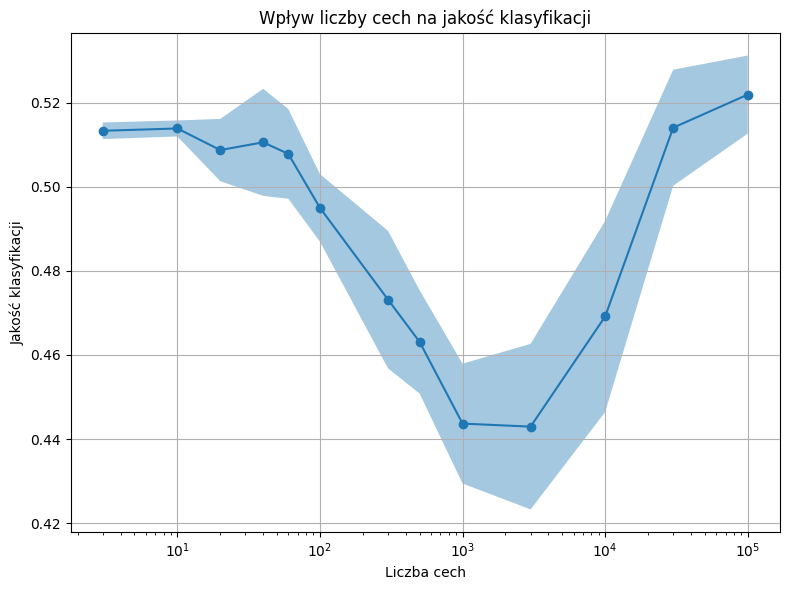

In [107]:
import numpy as np
import matplotlib.pyplot as plt

token_counts = [dict((token, tweet.tokens.count(token)) for token in set(tweet.tokens)) for tweet in training_set.tweets]
y = [x.clazz for x in training_set.tweets]

n_features_values = [3, 10, 20, 40, 60, 100, 300, 500, 1000, 3000, 10000, 30000, 100000]
means = []
stds = []

for n_features in n_features_values:
    hasher = FeatureHasher(n_features=n_features, input_type='dict')
    X = abs(hasher.transform(token_counts))
    nb = MultinomialNB()
    scores = cross_val_score(nb, X, y, cv=10, scoring='accuracy')
    means.append(scores.mean())
    stds.append(scores.std())
    print(f"n_features: {n_features}, accuracy: {scores.mean():.4f}")

plt.figure(figsize=(8, 6))
plt.plot(n_features_values, means, marker='o', linestyle='-')
plt.fill_between(n_features_values, np.array(means) - np.array(stds)/2, np.array(means) + np.array(stds)/2, alpha=0.4)
plt.xscale('log')
plt.xlabel('Liczba cech')
plt.ylabel('Jakość klasyfikacji')
plt.title('Wpływ liczby cech na jakość klasyfikacji')
plt.grid(True)
plt.tight_layout()
plt.show()

 - Obserwując stworzony wykres - skomentuj. Jak dużo jakości klasyfikacji się traci (albo zyskuje?) korzystając z mniejszej liczby haszowanych cech? Często klasyfikatory bardzo dobrze działają nawet przy liczbie haszowanych cech dla których na pewno istnieją konflikty cech oryginalnych - jak myślisz dlaczego? (Pomyśl o interpretacji takich skonfliktowanych cech).

Wykres pokazuje, że jakość klasyfikacji utrzymuje się na podobnym poziomie przy niskiej wymiarowości, następnie zaskakująco maleje w zakresie 1000 cech i ponownie rośnie osiągając najlepsze wyniki dla największych wymiarów. Pomimo małej liczby cech klasyfikator działa dobrze. Redukcja wymiaru może pełnić funkcję regularizacyjną, zmniejszając ryzyko przeuczenia. Konflikty cech bywają też neutralne lub wręcz korzystne, jeśli zagregowane wartości były również podobne na wejściu, co można osiągnąć z wykorzystaniem Locality-sensitive hashing.

 - W poprzednim zadaniu wczytałeś wynik grupowania Browna do pamięci. Wytrenuj klasyfikator na reprezentacji ,,Bag-of-clusters'' tj. w kolumnach zamiast słów/n-gramów będziesz miał grupy.

In [112]:
from sklearn.feature_extraction.text import CountVectorizer
word_to_cluster = dict(zip(brown_df['word'], brown_df['cluster'].astype(str)))
def words_to_clusters(tokens):
    return ' '.join([word_to_cluster[token] if token in word_to_cluster else 'UNK' for token in tokens])

documents = [words_to_clusters(tweet.tokens) for tweet in training_set.tweets]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(documents)
y = [x.clazz for x in training_set.tweets]

nb = MultinomialNB()
cross_val_score(nb, X, y, cv=10, scoring='accuracy').mean()

0.5394720569949929

- Podsumuj eksperymenty: poznałeś dwie możliwości ograniczenia liczby cech - zastąpienie słów ich grupami i haszowanie cech. Jakie są wady i zalety obydwu podejść?

Haszowanie:
 - wady:
   - potencjalni zbyt duże kolizje i zatracenie wiedzy
   - wymaga znalezienia odpowiedniego parametru ilości cech
 - zalety:
   - prosta implementacja - nie wymaga innych danych np. o grupach

Bag-of-clusters:
  - wady:
    - problem OOV - niektóre słowa mogą nie mieć przypisanych grup
    - brak zachowania kolejności tokenów
  - zalety:
    - zachowanie semantycznej spójności - clustry posiadają słowa o zbliżonym znaczeniu semantycznym, potencjał do generalizacji wiedzy